In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models #add models to the list
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from torch import nn, optim
from torchvision.models import resnet18
from nfnets import WSConv2d, WSConvTranspose2d, ScaledStdConv2d
from nfnets.agc import AGC #Needs testing

In [4]:
train_transform = transforms.Compose([
        #transforms.Resize(224),             # resize shortest side to 224 pixels
        #transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
                             ])

test_transform = transforms.Compose([
        #transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [8]:
root = '../data/fusion/eye_c-15/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'),transform=test_transform)


In [9]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = test_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
# Grab the first batch of 10 images
for images,labels in test_loader: 
    break


['16', '32', '8']
Training images available: 1050
Testing images available:  450


In [10]:
conv1 = nn.Conv2d(3,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)
for i, (X_train, y_train) in enumerate(train_data):
    break
cc,vv,zz =X_train.shape
x = X_train.view(1,3,vv, zz)
x = F.relu(conv1(x))
x= F.max_pool2d(x,2,2)
x = F.relu(conv2(x))
x = F.max_pool2d(x,2,2)
xxx, ccc,vvv,zzz= x.shape

Label: [2 1 2 2 2 2 2 1 0 1]
Class: 8 32 8 8 8 8 8 32 16 32


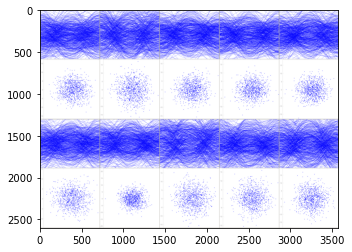

In [11]:
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)# 3,6,3,1 one color or three
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16*vvv*zzz, 120) #16*58*211
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)  # 3 is class outputs 

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*vvv*zzz) #two 16*105*118 #one 16*152*185
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

torch.manual_seed(101)
model = ConvolutionalNetwork()
#model = timm.create_model('resnet50' , pretrained= True ,num_classes = 3)
#model = timm.create_model('efficientnet_b4' , pretrained= True ,num_classes = 3)
#model = timm.create_model('mobilenetv3_large_100' , pretrained= True ,num_classes = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 

In [13]:
import time
start_time = time.time()

epochs = 1


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() #true 1/false 0
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0: #600
            '''
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/800]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            '''
            print(f"EPOCH: {i} BATCH: {b} LOSS: {loss.item()}")
            
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the Testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
# print the time elapsed
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

print(f'Test accuracy: {test_correct[-1].item()*100/450:.3f}%')

EPOCH: 0 BATCH: 10 LOSS: 1.3153717517852783
EPOCH: 0 BATCH: 20 LOSS: 1.0442732572555542
EPOCH: 0 BATCH: 30 LOSS: 1.2790709733963013
EPOCH: 0 BATCH: 40 LOSS: 1.0417081117630005
EPOCH: 0 BATCH: 50 LOSS: 1.1801173686981201
EPOCH: 0 BATCH: 60 LOSS: 1.0796775817871094
EPOCH: 0 BATCH: 70 LOSS: 1.1159584522247314
EPOCH: 0 BATCH: 80 LOSS: 0.9483515620231628
EPOCH: 0 BATCH: 90 LOSS: 0.8980029225349426
EPOCH: 0 BATCH: 100 LOSS: 0.9637063145637512

Duration: 447 seconds
Test accuracy: 68.222%
